### ETAS, fault traces, slip inversion
- A short notebook illustrating how to work with fault model traces and (not-)ETAS
- Invert the ETAS to estimate slip on fault elements
- NOTE: A few places where we show both the vectorized and non-vectorized implementation of a loop-loop, including a block-loop and a list comprehension. Note that the vectorized forms are literally a couple hundred times (guessing) faster.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
import glob
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
#from yodiipy import ANSStools as atp
#
#import contours2kml
#import globalETAS as gep
#import global_etas_auto as ggep
#from eq_params import *
#
#from nepal_figs import *
#import optimizers
#
import math
import random
import geopy
#
import pandas
import numba

#### Fault data:
- Load fault traces from an earlier version of VQ
- Fault traces can (probably -- unless we replace it in an update) be found via GitHub at:
    - https://github.com/markyoder/vq/tree/master/examples/fault_traces
    - ... and also with this notebook
    


In [3]:
# let's remember how to do fault traces...
# there is probably some code in vc_parser that does this, but as i recall, this part is \
# pretty straight forward.
#
# there are a bunch of fault files. we can either name the ones we want, or the ones we don't...  
# or we can generate a list.
#
# let's do a recarrray or maybe PANDAS (for practice). anyway, let's keep:
# falut_id, lon, lat, slip_rate
# slip_rate might be slip_rate*(1-aseis_fraction)
#
fault_data = []
#
fault_data_dir = 'vq_faults//fault_traces/ca_traces'
fault_files = glob.glob(os.path.join(fault_data_dir, '*.txt'))
#
cols = ['fault_id', 'lat', 'lon', 'altitude', 'depth', 'slip_rate']
#
for fl_name in fault_files:
    with open(fl_name, 'r') as fin:
        have_fault_id = False
        for rw in fin:
            if rw.startswith('#'):
                continue
            #
            if not have_fault_id:
                fault_id, n_elements, fault_nm = rw.split(' ')
                have_fault_id = True
                continue
            #
            #
            fault_data += [[fault_id] + [float(x) for x in rw.split()[0:5]]]
        
        #
    
    #
# remember how to use this later:
#fault_data_df = pandas.DataFrame(numpy.array(fault_data).T, index=cols)
#
# NOTE: there are other ways to build recarrays, besides core.records.fromarrays()
# it looks like .fromrecords() should ber the transpose
#. of .fromarrays(), but it isn't or, it isn't exactly. In any case, I've over the years found this method
#. to work very reliably and others to appear very promising, but sometimbe behave eratically.
#
fault_data = numpy.core.records.fromarrays(numpy.array(fault_data).T, dtype=[(nm,tp) for nm,tp in 
                                                zip(cols, ['<i8'] + ['<f8' for _ in cols[1:]])])

#### Do a quick plot of the fault traces

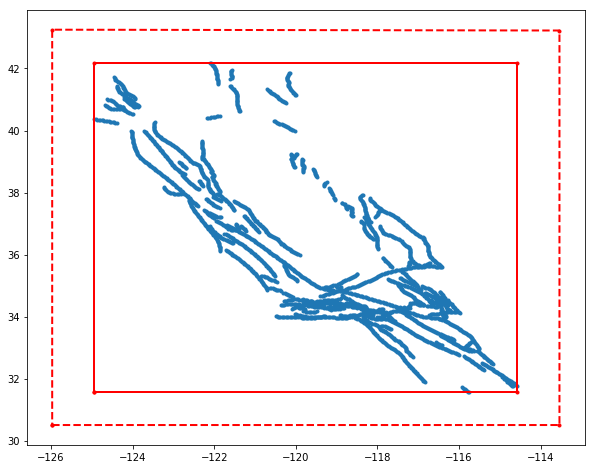

In [4]:
plt.figure(figsize=(10,8))
ll_lon, ll_lat = (min(fault_data['lon']), min(fault_data['lat']))
ur_lon, ur_lat = (max(fault_data['lon']), max(fault_data['lat']))
d_lat = ur_lat - ll_lat
d_lon = ur_lon - ll_lon
dd_lat = .1*d_lat
dd_lon = .1*d_lon
plt.plot(fault_data['lon'], fault_data['lat'], marker = '.', ls='')
#
plt.plot(*zip(*[(ll_lon, ll_lat), (ur_lon, ll_lat), (ur_lon, ur_lat), (ll_lon, ur_lat), (ll_lon, ll_lat)]),
        marker='.', ls= '-', color='r', lw=2.)
#
plt.plot(*zip(*[(ll_lon-dd_lon, ll_lat-dd_lat), (ur_lon+dd_lon, ll_lat-dd_lat), (ur_lon+dd_lon, ur_lat+dd_lon),
                (ll_lon-dd_lon, ur_lat+dd_lat), (ll_lon-dd_lon, ll_lat-dd_lat)]),
        marker='.', ls= '--', color='r', lw=2.)

### Compute Omori(-like) fields for the fault traces 
- The unweighted Omori-fault field elements are:
\begin{equation}
z^{uw}_{jk} = \sum_l{\frac{1}{1 + \left(\vec{x}^{map}_{jk} - \vec{x}^{fault}_l \right)}}
\end{equation}

- The weighted Omori-fault field elements are:
\begin{equation}
z^{w}_{jk} = \sum_l{\frac{slip_l}{1 + \left(\vec{x}^{map}_{jk} - \vec{x}^{fault}_l \right)}}
\end{equation}

where $\vec{x}^{map}_{jk}$ is the vector position of the $jk^{th}$ map element and $\vec{x}^{fault}_l$ is the vector position of the $l^{th}$ fault element. 

In [5]:
#
my_cmap = 'jet'
# TODO: see globalETAS.py for a version of this that supports vectorized inputs.
# also, probably better to require the math. namespace, so we can also use numpy.
# versions of these functions. I think the python math. version of these functions
# is actually as fast as numpy for scalar inputs, but vectorization is loads faster...
#
#from math import radians, cos, sin, asin, sqrt
#
#
# TODO: Evaluate how well @numba.jit(nopython=True) vectorizes this component by itself. 
#. use math.sin(), etc.
#@numba.jit(nopython=True)
@numba.jit
def haversine(lon1, lat1, lon2, lat2):
    # TODO: check this against my other haversine function(s); this one is ripped off from SourceForge.
    #
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    #lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    #lon1, lat1, lon2, lat2 = [math.radians(x) for x in (lon1, lat1, lon2, lat2)]
    lon1, lat1, lon2, lat2 = [numpy.radians(x) for x in (lon1, lat1, lon2, lat2)]
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = numpy.sin(dlat/2)**2 + numpy.cos(lat1) * numpy.cos(lat2) * numpy.sin(dlon/2)**2
    c = 2 * numpy.arcsin(numpy.sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371.* c
    #
    return km
#
@numba.jit(nopython=True)
def omori(x, x0=1., a=1., q=1.5):
    return a*((1.+ x/x0)**(-q))
#

In [6]:
# make a lattice:
lon_min = ll_lon - dd_lon
lat_min = ll_lat - dd_lat
lon_max = ur_lon + dd_lon
lat_max = ur_lat + dd_lat
#
#lon_bin, lat_bin = .1, .1
#
n_lon=100
n_lat=100
lons = numpy.linspace(lon_min, lon_max, n_lon)
lats = numpy.linspace(lat_min, lat_max, n_lat)
#

In [7]:
#ax.plot(*zip(*itertools.product(lons, lats)), marker='.', ls='')
#
# See vectorized version of this (but nominally keep this version to check output)
# XYZ = []
# XYZ_r = []
# for y1, x1 in itertools.product(lats, lons):
#     #XYZ_r = []
#     #XYZ += [[x1, y1, 0.]]
#     z=0.
#     z_r = 0.
#     # note: this loop is the dot product of the fault elements vector with the map_elements vector.
#     #    there might be some opportunities for programmatic optimization, like list comprehension or
#     #    a compiled .dot() function. also, can we jit-compile omori()
#     for y2,x2,v in zip(fault_data['lat'], fault_data['lon'], fault_data['slip_rate']):
#         dist = haversine(x1, y1, x2, y2)
#         #dist = numpy.sqrt((x2-x1)**2. + (y2-y1)**2.)
#         #z += numpy.log(omori(dist, a=v))
#         z += omori(dist, a=v)    # slip-weighted
#         z_r += omori(dist, a=1.)  # unweighted "1/r" field
#         #z += omori(dist, a=1.)
#     XYZ += [[x1, y1, z]]
#     XYZ_r += [[x1, y1, z_r]]
#     #
#     #
# #
# # TODO: vectorize! see above comments. Here are our array shapes. We do this first, then apply
# #. a vectorized version of haversine (or something like that). what we really want is a 3D block
# #. of x,y,event, then collapse (or sum) along the event-axis.
# z_ary = numpy.reshape(numpy.array([rw[2] for rw in XYZ]), (n_lon, n_lat))
# z_ary_r = numpy.reshape(numpy.array([rw[2] for rw in XYZ_r]), (n_lon, n_lat))
#

#
# plt.figure(figsize=(16,14))
# plt.clf()
# ax1 = plt.subplot('221')
# ax2 = plt.subplot('222')
# ax3 = plt.subplot('223')
# ax4 = plt.subplot('224')
# #
# #plt.figure(figsize=(8,6))
# #plt.clf()
# #ax3 = plt.gca()
# #
# t = ax1.imshow(z_ary[::-1], cmap=my_cmap)
# t = ax1.set_title('$1/r$ and slip field')
# t = ax1.set_xticklabels(lons)
# t = ax1.set_yticklabels(lats)
# #
# t = ax2.imshow(z_ary_r[::-1], cmap=my_cmap)
# t = ax2.set_title('$1/r$  field')
# t = ax2.set_xticklabels(lons)
# t = ax2.set_yticklabels(lats)
# #
# for y1, x1 in itertools.product(lats, lons):
#     ax3.plot(x1,y1, marker='.', ls='', color='m', alpha=.5)
# for y2,x2 in zip(fault_data['lat'], fault_data['lon']):
#     ax3.plot(x2,y2, marker='.', ls='', color='b')
# ax3.set_title('Lattice and Faults')
# #
# t = ax4.imshow(XY[::-1], cmap=my_cmap)

In [8]:
# vectorized...
# TODO: these might be transposed...
X,Y = numpy.meshgrid(lons, lats)
#
# I think there is a numpier way to do this -- maybe an outer product (i think outer() ???)
#, but this is a good start. i seem to remember trying (unsuccessfully) to do a 3D meshgrid once upon
#. a time. it's supposed to be supported, but only in newer versions of numpy, and it was not entirely
#. cooperative.
z_ary = numpy.sum(numpy.array([omori(haversine(X,Y, x,y), v)
                   for y,x,v in 
                   zip(fault_data['lat'], fault_data['lon'], fault_data['slip_rate'])]), axis=0)
#
z_ary_r = numpy.sum(numpy.array([omori(haversine(X,Y, x,y), 1.0)
                   for y,x,v in 
                   zip(fault_data['lat'], fault_data['lon'], fault_data['slip_rate'])]), axis=0)
#



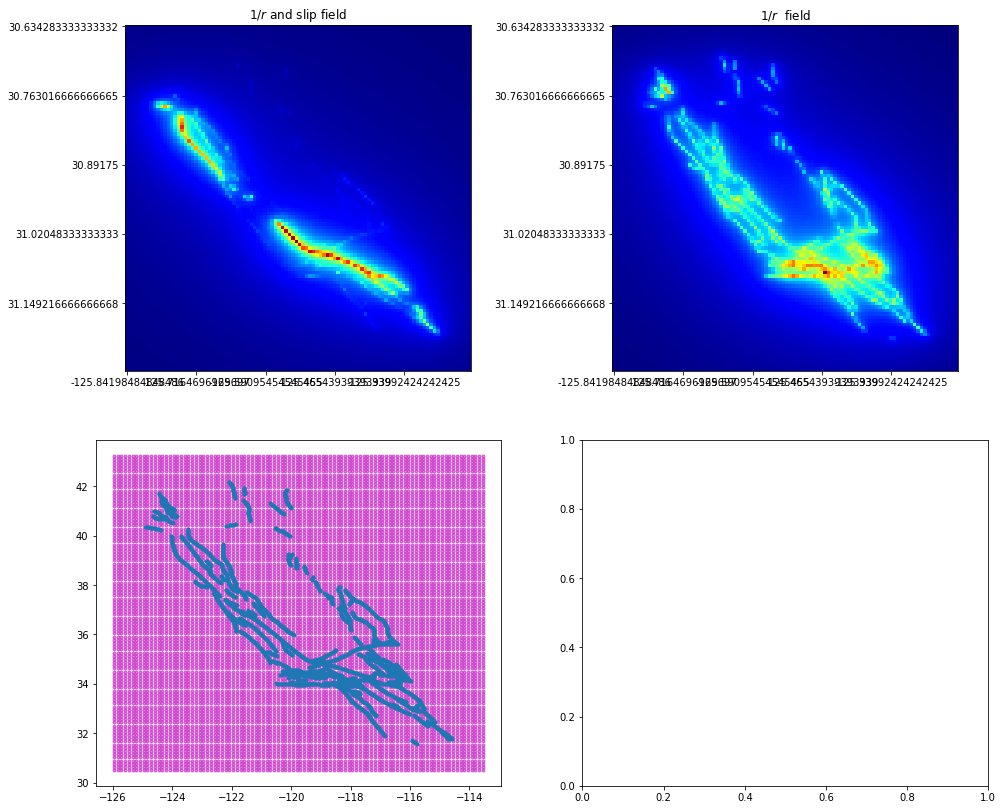

In [9]:
#
plt.figure(figsize=(16,14))
plt.clf()
ax1 = plt.subplot('221')
ax2 = plt.subplot('222')
ax3 = plt.subplot('223')
ax4 = plt.subplot('224')
#
# for good measure, dump the outputs to the dummy variablt t
t = ax1.imshow(z_ary[::-1], cmap=my_cmap)
t = ax1.set_title('$1/r$ and slip field')
t = ax1.set_xticklabels(lons)
t = ax1.set_yticklabels(lats)
#
t = ax2.imshow(z_ary_r[::-1], cmap=my_cmap)
t = ax2.set_title('$1/r$  field')
t = ax2.set_xticklabels(lons)
t = ax2.set_yticklabels(lats)
#
ax3.plot(*numpy.array(list(itertools.product(lons, lats))).T, marker='.', ls='', color='m', alpha=.5 )
ax3.plot(fault_data['lon'], fault_data['lat'], ls='', marker='.', zorder=11)
# for y1, x1 in itertools.product(lats, lons):
#     ax3.plot(x1,y1, marker='.', ls='', color='m', alpha=.5)
# for y2,x2 in zip(fault_data['lat'], fault_data['lon']):
#     ax3.plot(x2,y2, marker='.', ls='', color='b')
# ax3.set_title('Lattice and Faults')


### ... and we can plot with alternative color maps, for desired dramatic effect.

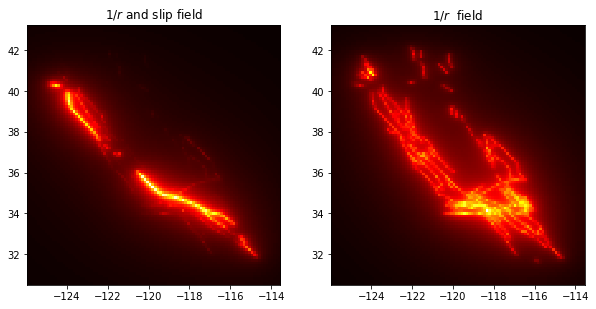

In [10]:
plt.figure(figsize=(10,8))
plt.clf()
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
#
t = ax1.imshow(z_ary, cmap='hot', extent=(min(lons), max(lons), min(lats), max(lats)), origin='bottom')
t = ax1.set_title('$1/r$ and slip field')
#t = ax1.set_xticklabels(['{:.2f}'.format(x) for x in lons])
#t = ax1.set_yticklabels(['{:.2f}'.format(x) for x in lats])
#
t = ax2.imshow(z_ary_r, cmap='hot', extent=(min(lons), max(lons), min(lats), max(lats)), origin='bottom')
t = ax2.set_title('$1/r$  field')
#t = ax2.set_xticklabels(['{:.2f}'.format(x) for x in lons])
#t = ax2.set_yticklabels(['{:.2f}'.format(x) for x in lats])


### Inverting the ETAS field for slip rates
- Given an ETAS rate-density field...
- ... and a fault map, without slips
- Compute a matrix of $1/r_{jk} = 1/(x_j - x_k)$, where $x_j$ is the location of a map site and $x_k$ is the location of a fault element.
- The slips (we're guessing that this number will be related to slip) can be found by inverting the matrix equation, $\hat{R} \cdot \vec{s} = \hat{etas}$
- A few Notes:
    - This is "slip" principally in spirit or name; this is some sort of slip-like "productivity" quantity
    - In this example we are computing just a scalar quantity -- net slip in some direction. Later, we'll wan to figure out how to constrain orientation and direction
    - Nominally, this focuses on more recent slip (since it's inverted from time-dependent ETAS).
    

In [11]:
print('lats: ', min(lats), max(lats))
print('lons: ', min(lons), max(lons))

lats:  30.50555 43.25015
lons:  -125.9675 -113.5415


### Load ETAS data:
- Most likely, what follows is ETAS "xyz" data computed earlier and offline.

In [12]:
# for each point on the map; one column for each falut element):
etas_xyz_file = 'vq_faults/fault_field_data/etas_Cali_general_2017-11-16_09:37:37.992632+00:00.xyz'
etas_xyz = numpy.genfromtxt(etas_xyz_file, delimiter='\t', names=True, skip_header=3, comments='#' )
etas_xyz.sort(order=('y','x'))
print('*** ', etas_xyz[0:5])
#

***  [(-126. , 30.5, 1.38285263e-14) (-125.9, 30.5, 1.40861471e-14)
 (-125.8, 30.5, 1.43520701e-14) (-125.7, 30.5, 1.46266975e-14)
 (-125.6, 30.5, 1.49104579e-14)]


#### Sampling the data...
- So one thing we can do is to, interpolate the faults data onto a regular lattice. note, we may not
use the slip data,
- but we do need something in the 'z' value to interpolate... so there might be a bette way to do this. if we really want to simulate an unknown fault model, we should just use z=1 for all elements.
- after we interpolate, we'll need to spin through with a binary discriminator to decide which pixels are on and off...
- ... but I have not decided, at this time, how useful this is.


/Users/myoder96/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=63,55 m=3225 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


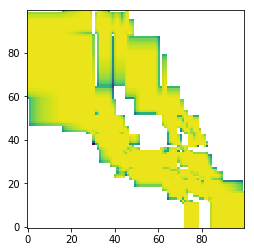

In [13]:
# so one thing we can do is to, interpolate the faults data onto a regular lattice. note, we may not
# use the slip data,
# but we do need something in the 'z' value to interpolate... so there might be a better
# way to do this. if we really want to simulate an unknown fault model, we should just use z=1
# for all elements. afert we interpolate, we'll need to spin through with a binary discriminator
# to decide which pixels are on and off...
faults_interp = scipy.interpolate.interp2d(x=fault_data['lon'], y=fault_data['lat'],
                                           z=numpy.ones(len(fault_data)))
#
#faults_interp = scipy.interpolate.interp2d(x=fault_data['lon'], y=fault_data['lat'],
#                                           z=fault_data['slip_rate'])
n_lon = 100
n_lat = 100
x_prime = numpy.linspace(min(fault_data['lon']), max(fault_data['lon']), n_lon)
y_prime = numpy.linspace(min(fault_data['lat']), max(fault_data['lat']), n_lat)
#
faults_prime = faults_interp(x=x_prime, y=y_prime)
#

plt.figure()
plt.imshow(numpy.log(faults_prime), origin='bottom')

### Interpolating for compute feasibility:
- For large, high resolution data sets (ETAS and fault models), it may be necessary to interpolate, to make the problem more computationally tractible
- We're going to be inverting a matrix, which is an ON3 process, so large matrices can get pretty ugly.
- Use scipy.interpolate...

In [31]:
#
lats_f = fault_data['lat']
lons_f = fault_data['lon']

lats_e = list(sorted(set(etas_xyz['y'])))
lons_e = list(sorted(set(etas_xyz['x'])))
etas_xyz.sort(order=('y','x'))
#
# first, sample-down our etas:
n_lon_e = 250
n_lat_e = 250
x_prime_e = numpy.linspace(min(etas_xyz['x']), max(etas_xyz['x']), n_lon)
y_prime_e = numpy.linspace(min(etas_xyz['y']), max(etas_xyz['y']), n_lat)

print('** create interpolators and compute etas_prime: ')
#etas_interp = scipy.interpolate.interp2d(x=etas_xyz['y'], y=etas_xyz['x'], z=etas_xyz['z'])
etas_interp = scipy.interpolate.interp2d(x=lons_e, y=lats_e, z=numpy.reshape(etas_xyz['z'], (len(lats_e),len(lons_e))))
etas_prime = etas_interp(x_prime_e, y_prime_e)
#
print('** etas_prime created. now plot figures...')

Xs = list(sorted(set(etas_xyz['x'])))
Ys = list(sorted(set(etas_xyz['y'])))
#
# active ETAS (to interpolate or not to interpolate...)
#my_etas_z = etas_prime.ravel()
#my_etas_xy = itertools.product(y_prime_e, x_prime_e)
#
# set aliases, my_etas_{}, in the event that we use interpolation.
# no interpolation
my_etas_z = etas_xyz['z']
#my_etas_xy = numpy.array([etas_xyz['x'], etas_xyz['y']]).T
my_etas_xy = etas_xyz[['x', 'y']]
#

#n_x = len(set([rw[0] for rw in my_etas_xy]))
#n_y = len(set([rw[1] for rw in my_etas_xy]))
n_x = len(numpy.unique(etas_xyz['x']))
n_y = len(numpy.unique(etas_xyz['y']))


** create interpolators and compute etas_prime: 
** etas_prime created. now plot figures...


In [32]:
# my_xy = etas_xyz[['x', 'y']]
# print('** shape: ', my_xy.shape, my_xy.dtype)

Text(0.5, 1.0, 'Interpolated')

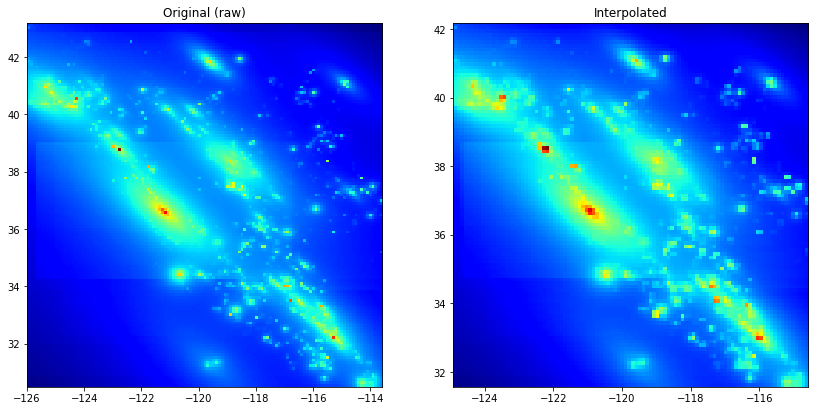

In [33]:
# diagnostic plot:
plt.figure(figsize=(14,12))
plt.clf()
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
etas_xyz.sort(order=('y', 'x'))
#Zs = numpy.reshape(etas_xyz['z'], (len(Ys), len(Xs)))
#ax.imshow(numpy.log(Zs), origin='lower', extent=(min(Xs), max(Xs), min(Ys), max(Ys)))
#
# "shape" keyword not working. tried both (len(X), len(Y)) and (len(Y), len(X))
# , shape=(len(Xs), len(Ys))
# ... but have another look.
ax1.imshow(numpy.reshape(numpy.log(etas_xyz['z']), (len(Ys), len(Xs))), origin='lower', 
          extent=(min(Xs), max(Xs), min(Ys), max(Ys)), cmap='jet')
ax2.imshow(numpy.log(etas_prime), origin='lower',
          extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap='jet')
#
ax1.set_title('Original (raw)')
ax2.set_title('Interpolated')


# get interpolation functions/objects for the ETAS (target) vector and the 1/r field. if we want to 
# reduce (interpolate) the 1/r field, we should do that before we compute the matrix -- because
# otherwise, we have to interpolate each column.
#
# let's interpolate onto the fault model basis (we could create a common basis and interpolate both
# data sets onto that, but this should be fine...)
# TODO: load etas data from a file (which will be exported offline)
#etas = numpy.genfromtxt(etas_xyz_file, delimiter='\t')
#

#
#

### Compute the $1/r$ matrix for the fault field
- Note: we typically perform this on the interpolated set, but this is surprisingly tractible with no interpolation.

In [45]:
#lats_f = lats_r
#lons_f = lons_r
print('** Construct 1/r array: ')
#Rs = [[omori(haversine(x1,y1,x2,y2), a=1.) for y2,x2 in zip(lats_f, lons_f)]
#      for y1, x1 in itertools.product(lats, lons)]
#
# full ETAS, no interpolation:
# loopy (albeit in list comprehension):
# Rs = [[omori(haversine(x1,y1,x2,y2), a=1.) for y2,x2 in zip(fault_data['lat'], fault_data['lon'])]
#       for x1, y1 in my_etas_xy]

# further vectorization; note the numpy.outer() outer product call...
# and it looks pretty much like the loop-loop version:
Rs = omori(haversine(my_etas_xy['x'].reshape(-1,1), my_etas_xy['y'].reshape(-1,1),
                        numpy.outer(numpy.ones(len(my_etas_xy)),fault_data['lon']), 
                            numpy.outer(numpy.ones(len(my_etas_xy)), fault_data['lat']) ) )
#
# interpolated ETAS.
#Rs = [[omori(haversine(x1,y1,x2,y2), a=1.) for y2,x2 in zip(fault_data['lat'], fault_data['lon'])]
#      for y1, x1 in itertools.product(y_prime_e, x_prime_e)]
#Rs = [[omori(haversine(x1,y1,x2,y2), a=1.) for y2,x2 in zip(fault_data['lat'], fault_data['lon'])]
#      for y1, x1 in my_etas_xy]


print('** 1/r array constructed; shape={}'.format(numpy.shape(Rs)))
#
print('** Now, invert; solve for slips from Rs and ETAS data')
#

** Construct 1/r array: 
** 1/r array constructed; shape=(16000, 3225)
** Now, invert; solve for slips from Rs and ETAS data


In [46]:
# so now, we can invert the matrix equation for the slips:
print('*** DEBUG: dims: ', numpy.shape(Rs), numpy.shape(etas_prime), numpy.size(etas_prime))
#
# regular least-squares solver:
#lsq_slips = numpy.linalg.lstsq(Rs, numpy.sqrt(etas_xyz['z']))
lsq_slips = scipy.optimize.nnls(Rs, numpy.sqrt(my_etas_z))
#lsq_slips = scipy.optimize.nnls(Rs, numpy.sqrt(etas_prime.ravel()))
etas_slips = lsq_slips[0]
#
# now, compare our etas_slips to the model slips. we should be able to do this initially by just 
## plotting the vector. we can, of course be more quantitative and also then compare a weighted 1/r field
# (like above).
#

*** DEBUG: dims:  (16000, 3225) (100, 100) 10000


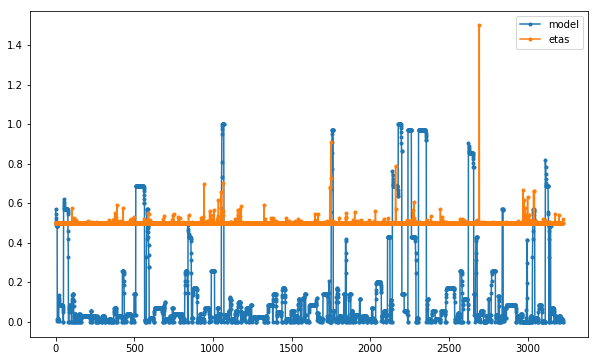

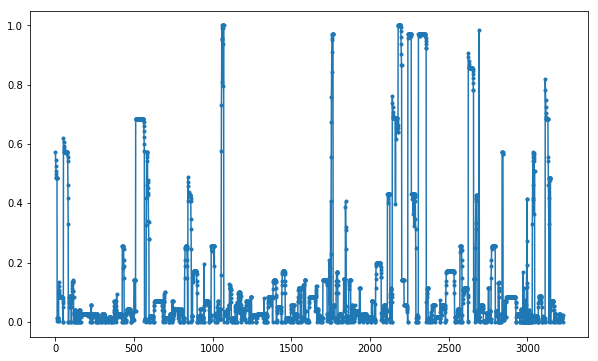

In [47]:
plt.figure(figsize=(10,6))
plt.clf()
ax = plt.gca()
model_normed = fault_data['slip_rate']/max(fault_data['slip_rate'])
ax.plot(model_normed, '.-', label='model')

#plt.figure(figsize=(10,6))
#plt.clf()
#ax = plt.gca()
etas_normed = (etas_slips)/max(etas_slips) 
ax.plot(.5 + etas_normed, '.-', label='etas')
ax.legend(loc=0)

plt.figure(figsize=(10,6))
plt.clf()
ax = plt.gca()
ax.plot(numpy.abs(model_normed - etas_normed), '.-', label='model')
#ax.plot(etas_slips, '.-', label='etas')

In [48]:
print('*** DEBUG: dims: ', numpy.shape(Rs), numpy.shape(etas_prime))

*** DEBUG: dims:  (16000, 3225) (100, 100)


In [49]:
print(len(etas_prime), len(etas_prime[0]))

100 100


In [50]:
model_slip_field = numpy.dot(Rs, etas_slips)

Text(0.5, 1.0, 'Reconstructed estimated slip/r field, from ETAS inversion')

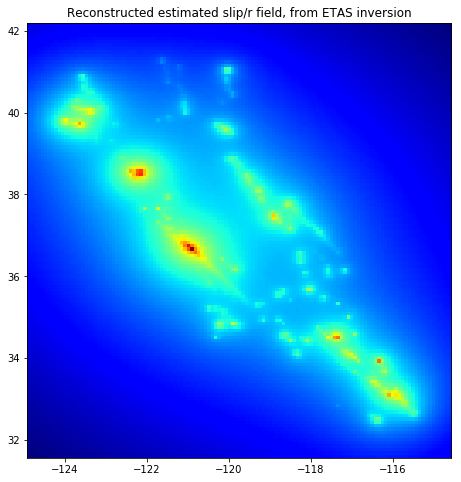

In [51]:
plt.figure(figsize=(10,8))
plt.clf()
ax=plt.subplot('111')
#
#z_etas = numpy.reshape(numpy.log(model_slip_field), (len(y_prime_e), len(x_prime_e)))
z_etas = numpy.reshape(numpy.log(model_slip_field), (n_y, n_x))
#
ax.imshow(z_etas, origin='bottom', 
         extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap='jet')
ax.set_title('Reconstructed estimated slip/r field, from ETAS inversion')

In [52]:
print(numpy.shape(z_ary), numpy.shape(model_slip_field), numpy.shape(z_etas))

(100, 100) (16000,) (128, 125)


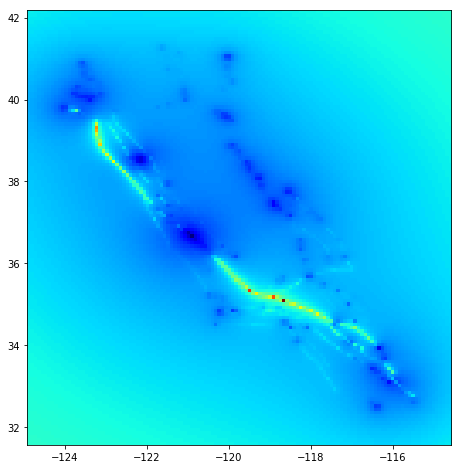

In [54]:
plt.figure(figsize=(10,8))
plt.clf()# 
ax=plt.gca()
#
diffs = (numpy.dot(Rs, fault_data['slip_rate'])-z_etas.ravel())**2.
diffs = numpy.reshape(diffs, (n_y, n_x))
#ax.imshow((z_etas-z_ary)**2., origin='bottom', extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap='jet')
ax.imshow(diffs, origin='bottom',
          extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap='jet')



Text(0.5, 1.0, 'ETAS (Interpolated)')

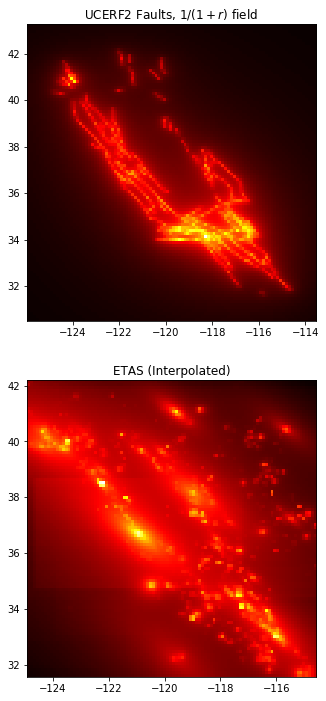

In [55]:
# for slides, a 2 axes image with 1/r field and ETAS images;

# diagnostic plot:
plt.figure(figsize=(14,12))
plt.clf()
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
etas_xyz.sort(order=('y', 'x'))
#Zs = numpy.reshape(etas_xyz['z'], (len(Ys), len(Xs)))
#ax.imshow(numpy.log(Zs), origin='lower', extent=(min(Xs), max(Xs), min(Ys), max(Ys)))
#
# "shape" keyword not working. tried both (len(X), len(Y)) and (len(Y), len(X))
# , shape=(len(Xs), len(Ys))
# ... but have another look.
#ax1.imshow(numpy.reshape(numpy.log(etas_xyz['z']), (len(Ys), len(Xs))), origin='lower', 
#          extent=(min(Xs), max(Xs), min(Ys), max(Ys)), cmap='jet')
ax1.imshow(z_ary_r, cmap='hot', extent=(min(lons), max(lons), min(lats), max(lats)), origin='bottom')

ax2.imshow(numpy.log(etas_prime), origin='lower',
          extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap='hot')
#
#ax1.set_title('Original (raw)')
ax1.set_title('UCERF2 Faults, $1/(1+r)$ field')
ax2.set_title('ETAS (Interpolated)')



Text(0.5, 1.0, 'Difference: $(z_{estimated} - z_{slips})^2$')

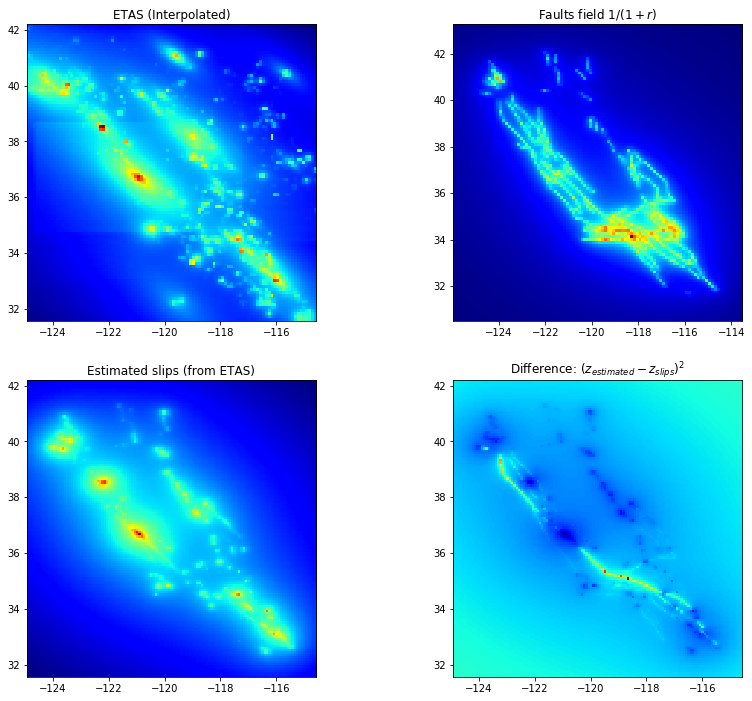

In [56]:
#
# slips, etas, diff plot:
cm = 'jet'
plt.figure(figsize=(14,12))
plt.clf()
ax1 = plt.subplot('221')
ax2 = plt.subplot('222')
ax3 = plt.subplot('223')
ax4 = plt.subplot('224')
#
etas_xyz.sort(order=('y', 'x'))
#Zs = numpy.reshape(etas_xyz['z'], (len(Ys), len(Xs)))
#ax.imshow(numpy.log(Zs), origin='lower', extent=(min(Xs), max(Xs), min(Ys), max(Ys)))
#
# "shape" keyword not working. tried both (len(X), len(Y)) and (len(Y), len(X))
# , shape=(len(Xs), len(Ys))
# ... but have another look.
# ETAS:
ax1.imshow(numpy.log(etas_prime), origin='lower',
          extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap=cm)
ax1.set_title('ETAS (Interpolated)')
#
# 1/r field:
ax2.imshow(z_ary_r, cmap=cm, extent=(min(lons), max(lons), min(lats), max(lats)), origin='bottom')
ax2.set_title('Faults field $1/(1+r)$')
#
# slip field:
#ax2.imshow(z_ary, cmap=cm, extent=(min(lons), max(lons), min(lats), max(lats)), origin='bottom')
#ax2.set_title('Slip field $\Delta x/(1+r)$')
#
# estimated slips:
ax3.imshow(z_etas, origin='bottom', extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap=cm)
ax3.set_title('Estimated slips (from ETAS)')
#
# diff:
#ax4.imshow((z_etas-z_ary)**2., origin='bottom', extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap='jet')
ax4.imshow(diffs, origin='bottom', extent=(min(lons_f), max(lons_f), min(lats_f), max(lats_f)), cmap='jet')

ax4.set_title('Difference: $(z_{estimated} - z_{slips})^2$')
#